In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

## Data Loading

In [2]:
# read the datafile
df_initial = pd.read_csv('/Users/yueliu/ds_side_projects/customer_segmentation/trim.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (50000, 8)


In [3]:
df_initial.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df_initial.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

## Exploratory Data Analysis

In [5]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [6]:
df_initial.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

### Identify null values

In [7]:
# create a table to include columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'percentage of null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )

display(tab_info)

---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,142,0,0,0,17881,0
percentage of null values (%),0.0,0.0,0.284,0.0,0.0,0.0,35.762,0.0


### Remove data entries
Note: there are about 35% records not having CustomerID, so it is impossible to map values for the customers and these records. These records are useless for this exercise and they will be removed from dataset.

In [8]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'percentage of null values (%)'}))
display(tab_info)

Dataframe dimensions: (32119, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,0,0,0,0,0,0
percentage of null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_initial[df_initial.duplicated()==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
...,...,...,...,...,...,...,...,...
49646,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735,United Kingdom
49647,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735,United Kingdom
49648,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735,United Kingdom
49650,540524,21326,AGED GLASS SILVER T-LIGHT HOLDER,12,2011-01-09 12:53:00,0.65,16735,United Kingdom


In [10]:
df_initial[(df_initial.InvoiceNo=='536409') & (df_initial.StockCode=='21866')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom


In [11]:
#check total number of duplicate records and drop them
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 533


### Exploring data attributes

#### Exploring the data attribute : Country 

In [12]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataset: {}'.format(len(countries)))

No. of cuntries in dataset: 23


In [13]:
temp_num_of_order_per_country = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_num_of_order_per_country = temp_num_of_order_per_country.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_num_of_order_per_country.sort_values(by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
            Country  Country wise number of order
22   United Kingdom                         28654
9           Germany                           810
8            France                           608
6              EIRE                           377
19            Spain                           174
16           Norway                           147
18         Portugal                           141
2           Belgium                            99
0         Australia                            82
4            Cyprus                            82
15      Netherlands                            72
13            Japan                            69
21      Switzerland                            49
12            Italy                            42
20           Sweden                            41
14        Lithuania                            35
10          Iceland                            31
5           Denmark                            2

#### Exploring the data attribute : Customers and products

In [14]:
#Display the number of transactions, products and customers in the dataset
pd.DataFrame({'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }, columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,2501,1979,1039


Based on above result, this dataset contain the recods of 1039 users who bought 2501 different items. There are about 
1979 transactions. Next, explore the number of products purchased in every transaction by each customer.

In [15]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].count()
num_products_per_trans = temp.rename(columns = {'Quantity':'Number of products'})
num_products_per_trans[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12347,537626,31
1,12348,539318,17
2,12370,538826,82
3,12370,539330,8
4,12377,539488,43
5,12383,539840,37
6,12386,537676,8
7,12386,540280,2
8,12395,537026,12
9,12395,539447,19


In [17]:
df_initial[df_initial['InvoiceNo'].str.contains("^C")].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Findings to be noted here:

There are some users who bought only one or two times on the E-commerce platform and purchased one item. The example of this kind of user is customerID 12386.

There are some users who frequently buy large number of items per order. The example of this kind of user is customerID 12347.

There is prefix 'C' for some InvoiceNo records. This 'C' indicates that the particular transaction has been cancelled.

#### Analysis of cancelled orders

In [18]:
# count the number of transactions corresponding to cancelled orders
num_products_per_trans['order_cancelled'] = num_products_per_trans['InvoiceNo'].apply(lambda x:int('C' in x))
display(num_products_per_trans[-5:])


n1 = num_products_per_trans['order_cancelled'].sum()
n2 = num_products_per_trans.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} = {:.2f}% '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
1974,18260,539315,11,0
1975,18260,540539,26,0
1976,18269,537817,7,0
1977,18269,C539278,1,1
1978,18283,540350,57,0


Number of orders cancelled: 362/1979 = 18.29% 


About 18% product orders got cancelled. Example is InvoiceNo C541433. Need to further check all cancelled orders to verify if a negative quantity is systematically to the same positive quantity, with the same description (CustomerID, Description and UnitPrice):

In [19]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df_check.head(3)

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65


In [20]:
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: #search for if negative record not have symmetirc positve record
        
        print(df_check.loc[index])
        print(10*'-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
----------> HYPOTHESIS NOT FULFILLED


Obviously the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. Check again the hypothesis but this time discarding the 'Discount' entries.

In [21]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        
        print(df_check.loc[index])
        print(10*'-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
----------> HYPOTHESIS NOT FULFILLED


Once again, the initial hypothesis is not verified. It means cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, create a new variable in the dataframe that indicates if part of the demand has been canceled. Below, I make a census of the cancel orders and check for the existence of counterparts:

In [22]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

#create two lists to store entries that are to be deleted and in question
entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [23]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 414
doubtfull_entry: 447


Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no demand beforehand. In practice, I decide to delete all of these entries, which count for about 0.8% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [24]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of entries to delete: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


#### Analysis of Transaction Price

In [25]:
#create a new variable that indicates the total price of every purchase:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
14956,537626,22195,LARGE HEART MEASURING SPOONS,12,2010-12-07 14:57:00,1.65,12347,Iceland,0,19.80
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland,0,17.00
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland,0,39.00
14968,537626,20782,CAMOUFLAGE EAR MUFF HEADPHONES,6,2010-12-07 14:57:00,5.49,12347,Iceland,0,32.94
14967,537626,20780,BLACK EAR MUFF HEADPHONES,12,2010-12-07 14:57:00,4.65,12347,Iceland,0,55.80


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made by each CustomerID during a single order to recover the total order price:

In [26]:
# sum of purchases per user and order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()

basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12347,537626,711.79,2010-12-07 14:57:00.000001024
1,12348,539318,892.80,2010-12-16 19:09:00.000000000
2,12370,538826,1587.07,2010-12-14 12:58:00.000002816
3,12370,539330,277.20,2010-12-17 09:38:00.000000000
4,12377,539488,1001.52,2010-12-20 09:37:00.000001280
5,12383,539840,600.72,2010-12-22 14:28:00.000000000


In order to have a global view of the cost of orders in this dataset, draw a pie chart to see how the purchases are divided according to total prizes.

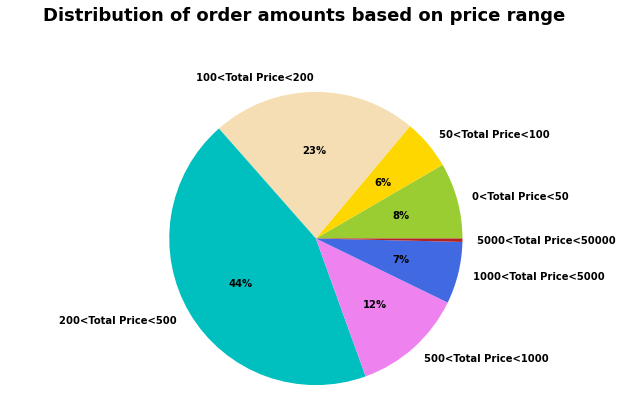

In [27]:
# Purchase count between each pre-defined interval in the range
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000] #range is 0 to 50000, 8 intervals incuding more than 50000
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<Total Price<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts based on price range", ha='center', fontsize = 18);

It can be seen that the about 63% purchases orders are greater than 200.

### Recency

In [28]:
df_cleaned["InvoiceDate"].max() # Last invoice date

Timestamp('2011-01-09 15:13:00')

In [29]:
today_date = dt.datetime(2011,12,9) # last invoice date is assigned to today_date variable
today_date

datetime.datetime(2011, 12, 9, 0, 0)

In [30]:
# Grouping the CustomerID variable, finding each ID's the last invoice dates, subtracting them from today_date, 
#and assigning them as recency
recency = (today_date - df_cleaned.groupby("CustomerID").agg({"InvoiceDate":"max"}))
# Rename column name as Recency
recency.rename(columns = {"InvoiceDate":"Recency"}, inplace = True)
# Change the values to day format
recency_df = recency["Recency"].apply(lambda x: x.days)
recency_df.head()

CustomerID
12347    366
12348    357
12370    356
12377    353
12383    351
Name: Recency, dtype: int64

### Frequency
In order to find the purchasing frequency of each customer, I need to determine how often the customers make purchases.

In [31]:
# Grouping unique values of invoice date according to CustomerID variable and assigning them to freq_df variable
freq_df = df_cleaned.groupby("CustomerID").agg({"InvoiceDate":"nunique"}) 
# Rename column name as Frequency
freq_df.rename(columns={"InvoiceDate": "Frequency"}, inplace=True)
freq_df.head()

,Frequency
CustomerID,
12347,1
12348,1
12370,2
12377,1
12383,1


### Monetary
In order to find the monetary value of each customer, I need to determine how much do the customers spend on purchases

In [32]:
# Grouping and sum up total prices according to each CustomerID
monetary_df = df_cleaned.groupby("CustomerID").agg({"TotalPrice":"sum"})
# Rename Total Price column as Monetary
monetary_df.rename(columns={"TotalPrice":"Monetary"}, inplace=True)
monetary_df.head()

,Monetary
CustomerID,
12347,711.79
12348,892.80
12370,1864.27
12377,1001.52
12383,600.72


### Concatenate Recency,Frequency and Monetary

In [33]:
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,366,1,711.79
12348,357,1,892.80
12370,356,2,1864.27
12377,353,1,1001.52
12383,351,1,600.72


<AxesSubplot:>

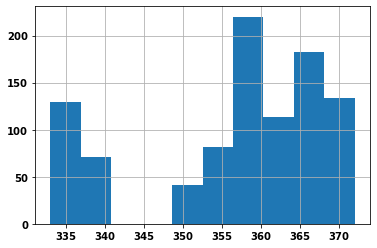

In [34]:
#check distribution of variables of interest
rfm['Recency'].hist()

<AxesSubplot:>

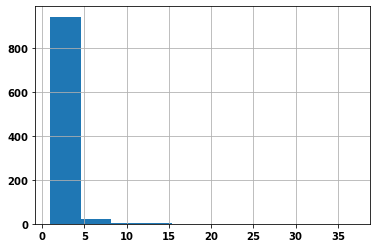

In [35]:
rfm['Frequency'].hist() 

<AxesSubplot:>

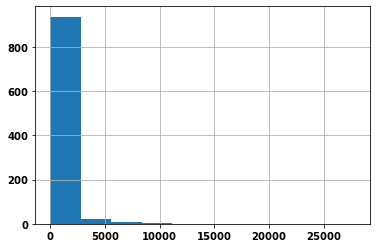

In [36]:
rfm['Monetary'].hist()

It can be seen all three features are skewed, so log transformation is needed to normalized the data

In [37]:
rfm_log = np.log(rfm)
rfm_log.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12347,5.902633,0.000000,6.567783
12348,5.877736,0.000000,6.794363
12370,5.874931,0.693147,7.530625
12377,5.866468,0.000000,6.909274
12383,5.860786,0.000000,6.398129


In [38]:
#scale data
stdscale = sklearn.preprocessing.StandardScaler()
stdscale.fit(rfm_log)
rfm_scaled = stdscale.transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [39]:
rfm_scaled.head(5)

,Recency,Frequency,Monetary
0,0.754287,-0.608146,0.659054
1,0.028233,-0.608146,0.889916
2,-0.053567,0.739899,1.640092
3,-0.300353,-0.608146,1.006999
4,-0.466045,-0.608146,0.486194


### K-means model for rfm dataset

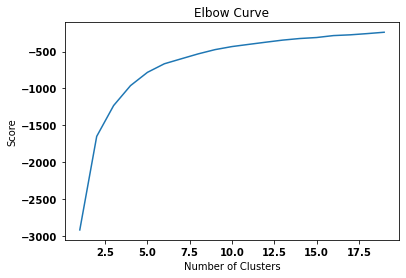

In [40]:
# get right number of cluster for K-means so looping from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
num_of_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in num_of_cluster]
score = [kmeans[i].fit(rfm_scaled).score(rfm_scaled) for i in range(len(kmeans))]
plt.plot(num_of_cluster,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

When number of clusters is about 5, the Elbow curve stops changing significantly. So assigning 5 clusters to the dataset

In [41]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=5, random_state=3).fit(rfm_scaled)

In [42]:
#creates a new column called cluster that has cluster number for each row respectively.
rfm['cluster'] = kmeans.labels_

In [43]:
rfm.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12347,366,1,711.79,0
12348,357,1,892.80,0
12370,356,2,1864.27,2
12377,353,1,1001.52,0
12383,351,1,600.72,0


<AxesSubplot:xlabel='cluster', ylabel='Recency'>

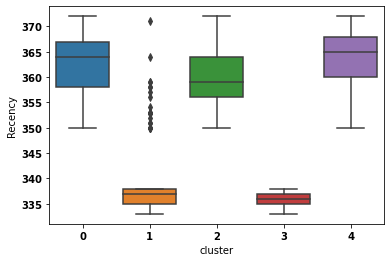

In [44]:
# explore recency distribution
sns.boxplot(x=rfm.cluster, y=rfm.Recency)

cluster 1 and cluster 3 have low recency meaning customers made purchase recently. cluster 0 and cluster 4 have high recency meaning customers did not purchase recently. cluster 2 is a little better than cluster 0 and 4.

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

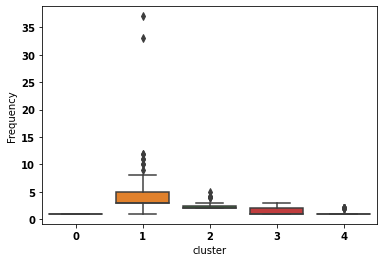

In [45]:
# explore frequency distribution
sns.boxplot(x=rfm.cluster, y=rfm.Frequency)

cluster 1 has the highest frequency meaning the customers in this cluster make purchase quite often. cluster 2 is the second highest frequent buyers. cluster 3 purchased less frequently than cluster 2. cluster 0 and 4 are very inactive buyers.

<AxesSubplot:xlabel='cluster', ylabel='Monetary'>

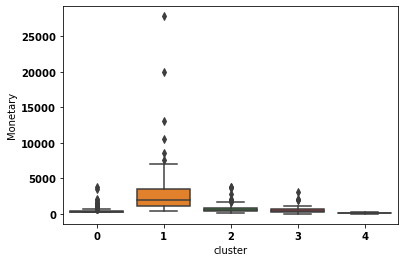

In [46]:
# explore monetary distribution
sns.boxplot(x=rfm.cluster, y=rfm.Monetary)

cluster 1 has the highest montary value, followed by cluster 2 and 3. cluster 0 and 4 contribute the lowest value.

With the recency, frequency and monetary boxplot distribution shown above, we can see:

cluster 1 is the most valueable customers. The business cannot lose them.

cluster 3 could be new customers who made purchases recently yet not frequently, they contributed decent amunt of revenue to the business. 

cluster 2 could be about-to-leave customers that they used to purchase frequently but for some reason they did not purchase recently. 

cluster 0 could be hibernating customers, they did not purchase recently nor frequently but their previous purchase contributed some amount of the revenue. 

cluster 4 needs attention because they did not purchase recently nor frequently and their purchase value is the lowest among all customers.

In [47]:
# Mapping of segments 
seg_map = {
    r'0': 'Hibernating Customers',
    r'1': 'Most Valuable Customers',
    r'2': 'About-to-Leave',
    r'3': 'New Customers',
    r'4': 'Need Attention'
}

In [48]:
rfm.rename(columns={'cluster': 'Segment'}, inplace=True)
rfm['Segment'] = rfm['Segment'].astype(str)
rfm.head()

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12347,366,1,711.79,0
12348,357,1,892.80,0
12370,356,2,1864.27,2
12377,353,1,1001.52,0
12383,351,1,600.72,0


In [49]:
# Segments are changed with the definitons of seg_map
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12347,366,1,711.79,Hibernating Customers
12348,357,1,892.80,Hibernating Customers
12370,356,2,1864.27,About-to-Leave
12377,353,1,1001.52,Hibernating Customers
12383,351,1,600.72,Hibernating Customers


In [50]:
# Mean, median, count statistics of different segments
rfm[["Segment","Recency","Frequency", "Monetary"]].groupby("Segment").agg(["mean","median","count"])

Recency              Frequency               \
                               mean median count      mean median count   
Segment                                                                   
About-to-Leave           359.640719    359   167  2.317365      2   167   
Hibernating Customers    362.656627    364   332  1.000000      1   332   
Most Valuable Customers  340.322581    337    93  4.881720      3    93   
Need Attention           364.380952    365   252  1.051587      1   252   
New Customers            335.589147    336   129  1.364341      1   129   

                            Monetary                  
                                mean    median count  
Segment                                               
About-to-Leave            757.396707   563.540   167  
Hibernating Customers     465.098102   351.525   332  
Most Valuable Customers  3136.000860  1910.400    93  
Need Attention            143.245238   147.475   252  
New Customers             488.754109   379.440   129

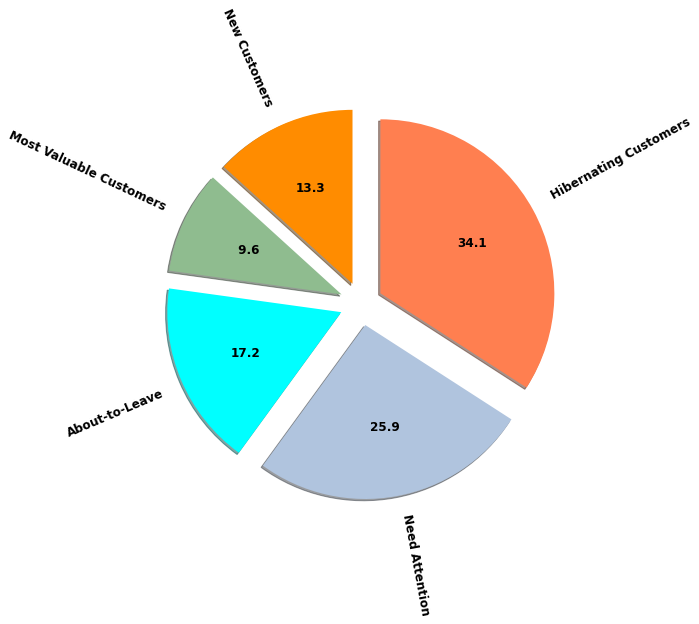

In [52]:
colors  = ("darkorange", "darkseagreen", "cyan",  "lightsteelblue", "coral")
explodes = [0.25, 0.25, 0.25, 0.25, 0.25]

rfm["Segment"].value_counts(sort=False).plot.pie(colors=colors,
                                                 textprops={'fontsize': 12}, 
                                                 autopct = '%4.1f',
                                                 startangle= 90, 
                                                 radius =2, 
                                                 rotatelabels=True,
                                                 shadow = True, 
                                                 explode = explodes)
plt.ylabel("")